# Basic tutorial: Interpolating bands, Berry curvatures, and integrating them

In this tutorial we will see how to compute band energies, Berry curvature, spins and anomalous Hall conductivity  using WannierBerri code and further integrate them over the Brillouin zone to obtain Anomalous Hall conductivity, and other quantities of interest.

## Preparation of a calculation:

* import the needed modules

* initialize a [Parallel() or Serial()](https://wannier-berri.org/docs/parallel.html) class 


In [1]:
# Preliminary 

# Set environment variables - not mandatory but recommended if you use Parallel()
#import os
#os.environ['OPENBLAS_NUM_THREADS'] = '1' 
#os.environ['MKL_NUM_THREADS'] = '1'


import wannierberri as wberri
print (f"Using WannierBerri version {wberri.__version__}")
import numpy as np
import scipy
import matplotlib.pyplot as plt
from termcolor import cprint

#  This block is needed if you run this cell for a second time
#  because one cannot initiate two parallel environments at a time
try:
    parallel.shutdown()   
except NameError:
    pass

# Chiose one of the options:

parallel = wberri.Parallel(num_cpus=2)
#parallel = wberri.Parallel()  # automatic detection 
#parallel = wberri.Serial()



Using WannierBerri version 0.13.5


2023-08-12 01:49:27,095	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


## Reading the system

Now we need to define the system that we are working on. Wannierberri can equally work with Wannier functions obtained by Wannier90 or other code (e.g. ASE or FPLO), as well as tight-binding models. This is done by constructing a [System()](https://wannier-berri.org/docs/system.html) class or one of its subclasses. Below, an example for Wannier90 is given; in advanced tutorials, some tight-binding models are also used.

In [2]:
# Importing data from wannier90

system=wberri.System_w90(
                        seedname='w90_files/Fe',
                        berry=True,   # needed to calculate "external terms" of Berry connection or curvature , reads ".mmn" file
                        spin = True , # needed for spin properties, reads ".spn" file
                        use_wcc_phase=True  # include the fphase actors e^(i*k*r_a) in the Bloch basis state definition
                        )

generators=["Inversion","C4z","TimeReversal*C2x"]
system.set_symmetry(generators)


using fortio to read
Reading restart information from file w90_files/Fe.chk :
Time to read .chk : 0.12518978118896484
Time for MMN.__init__() : 0.4363842010498047 , read : 0.42250633239746094 , headstring 0.01387786865234375
----------
 SPN  
---------

using fortio to read
reading w90_files/Fe.spn : Created on  7May2022 at 16: 2:47                            
----------
 SPN OK  
---------

time for FFT_q_to_R : 0.014847517013549805 s
using ws_distance
irvec_new_all shape (89,)
using ws_dist for Ham
using ws_dist for AA
using ws_dist for SS
Number of wannier functions: 18
Number of R points: 89
Recommended size of FFT grid [4 4 4]
Real-space lattice:
 [[ 1.4349963  1.4349963  1.4349963]
 [-1.4349963  1.4349963  1.4349963]
 [-1.4349963 -1.4349963  1.4349963]]


## Interpolation on a path

In [3]:
# Evaluate bands, Berry curvature, and spin along a path GHPNG


# all kpoints given in reduced coordinates
path=wberri.Path(system,
                 k_nodes=[
        [0.0000, 0.0000, 0.0000 ],   #  G 
        [0.500 ,-0.5000, -0.5000],   #  H 
        [0.7500, 0.2500, -0.2500],   #  P 
        [0.5000, 0.0000, -0.5000],   #  N 
        [0.0000, 0.0000, 0.000  ] ] , #  G 
                 labels=["G","H","P","N","G"],
                 length=200 )   # length [ Ang] ~= 2*pi/dk

# uncomment some of these lines to see what path you have generated

#print (path)

#print (path.getKline())

#for K in path.get_K_list():
#    print (K)

#print (np.array([K.K for K in path.get_K_list()]))



## Running a calculation: calculators and results

The calculation is called using the function [`run()`](https://wannier-berri.org/docs/run.html) : 

```
result=wberri.run(system, 
                  grid=path, 
                  calculators = {"key" : calculator},
                  parallel = parallel, 
                  print_Kpoints = False)
```
Here, apart from the already known ingredients, we need to define objects of some subclass of [`Calculator`](https://wannier-berri.org/docs/calculators.html#wannierberri.calculators.Calculator). A Calculator is a  callable object which returns some [`Result`](https://wannier-berri.org/docs/result.html). If you code another calculator, you can calculate other things using the machinery of WannierBerri, but that is not a part of this basic tutorial. 

Further, results are packed into [`ResultDict`](https://wannier-berri.org/docs/result.html#wannierberri.result.ResultDict) and returned. 


## Tabulating Berry curvature and spin

To run a tabulation one needs to compose a dictionary, where keys are any arbitrary strings to label further tabulation results, and the values are subclasses of [`Tabulator`](https://wannier-berri.org/docs/calculators.html#wannierberri.calculators.tabulate.Tabulator)

Next, we pack them into another class called [`TabulatorAll`](https://wannier-berri.org/docs/calculators.html#wannierberri.calculators.TabulatorAll), which represents a complex [`Calculator`](https://wannier-berri.org/docs/calculators.html#wannierberri.calculators.Calculator)

In [4]:

tabulators = { "Energy": wberri.calculators.tabulate.Energy(),
               "berry" : wberri.calculators.tabulate.BerryCurvature(),
             }

tab_all_path = wberri.calculators.TabulatorAll(
                    tabulators,
                    ibands = np.arange(0,18),
                    mode = "path"
                        )

calculator not described

calculator not described



### Running a calculation

Now run the calculation using the function [`run()`](https://wannier-berri.org/docs/run.html) . This will return an object of class [`ResultDict()`](https://wannier-berri.org/docs/result.html#wannierberri.result.ResultDict)
This object contains all results of the calculations, but in this case we have only one, which is marked `"tabulate"`


In [5]:
result=wberri.run(system, 
                  grid=path, 
                  calculators = {"tabulate" : tab_all_path},
                  parallel = parallel, 
                  print_Kpoints = False)

print (result.results)
path_result = result.results["tabulate"]


Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.TabulatorAll object at 0x7f4bd7109be0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 215 points and labels {0: 'G', 70: 'H', 130: 'P', 165: 'N', 214: 'G'}
generating K_list
Done 
Done, sum of weights:215.0
symgroup : None
processing 215 K points : using  2 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing    215 K-points on   2 processes:     2.5064 ; per K-point          0.0117 ; proc-sec per K-point          0.0233
time1 =  0.010695457458496094
Totally processed 215 K-points 
{'tabulate': <wannierberri.result.__tabresult.TABresult object at 0x7f4b4437c6d0>}


### Plotting the results

The [`TABresult`](https://wannier-berri.org/docs/result.html#wannierberri.result.TABresult) object already provides methods to plot the results. (As well as one can extract the data and plot them by other means). Below let's plot the interpolated bands and compare with those obtained in QE. (file "bands/Fe_bands_pw.dat" is already provided)


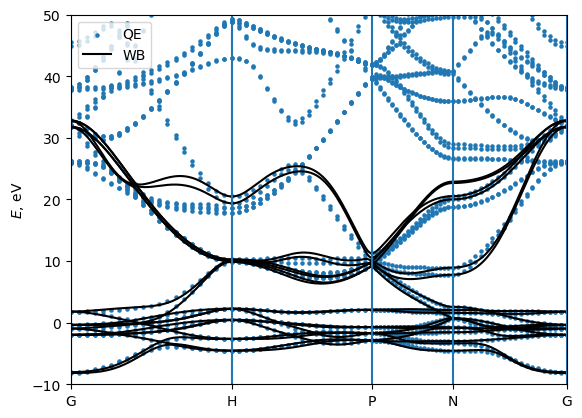

In [6]:
# plot the bands and compare with QuantumEspresso
EF = 12.6
path_result = result.results["tabulate"]
# Import the pre-computed bands from quantum espresso
A = np.loadtxt(open("bands/Fe_bands_pw.dat","r"))
bohr_ang = scipy.constants.physical_constants['Bohr radius'][0] / 1e-10
alatt = 5.4235* bohr_ang
A[:,0]*= 2*np.pi/alatt
A[:,1]-=EF
# plot it as dots
plt.scatter (A[:,0],A[:,1],s=5,label = "QE")


path_result.plot_path_fat( path,
              quantity=None,
              save_file="Fe_bands+QE.pdf",
              Eshift=EF,
              Emin=-10,  Emax=50,
              iband=None,
              mode="fatband",
              fatfactor=20,
              cut_k=False, 
              close_fig=False,
              show_fig=False,
              label = "WB"
              )


plt.legend()
plt.show()
plt.close()


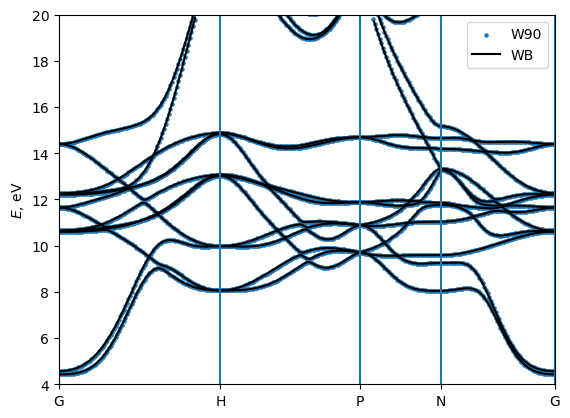

In [7]:
# plot the bands and compare with wannier90
A = np.loadtxt(open("bands/Fe_bands_w90.dat","r"))
plt.scatter (A[:,0],A[:,1],s=5,label = "W90")

path_result.plot_path_fat( path,
              quantity=None,
              save_file="Fe_bands+w90.pdf",
              Eshift=0,
              Emin=4,  Emax=20,
              iband=None,
              mode="fatband",
              fatfactor=20,
              cut_k=False, 
              close_fig=False,
              show_fig=False,
              label = "WB"
              )

plt.legend()

plt.show()
plt.close()

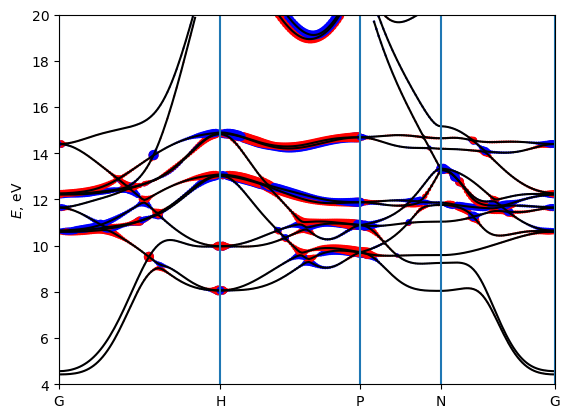

In [8]:
# plot the Berry curvature
path_result.plot_path_fat( path,
              quantity='berry',
              component='z',
              save_file="Fe_bands+berry.pdf",
              Eshift=0,
              Emin=4,  Emax=20,
              iband=None,
              mode="fatband",
              fatfactor=4,
              cut_k=False, 
              close_fig=True,
              show_fig=True
              )

# The size of the dots corresponds to the magnitude of BC on a logarithmic scale

### Problem 1:

* modify the path
* plot the "z" component of spin along it (without . 
* do **not** plot QE or W90 bands in this case

Hint : look here for a proper Calculator https://wannier-berri.org/docs/calculators.html#tabulating


In [ ]:
# put the necessary code here






### Get the data and do whatever you want

In [9]:
k=path.getKline()
E=path_result.get_data(quantity='Energy',iband=(10,11))
curv=path_result.get_data(quantity='berry',iband=(10,11),component="z")
print (k.shape, E.shape, curv.shape)

(215,) (215, 2) (215, 2)


## Calaculation on a 3D grid

Now let's investigate how Berry curvature behaves in the 3D  Brillouin zone. For that we need to set a grid, which can be done in several ways, see input parameters [here](file:///home/stepan/github/wannier-berri-org/html/docs/grid.html)

Most important to recall, is that in WB one sets two grids : the FFT grid and the K-grid (NKdiv). this is important for running the calculation. However, the final; result depends only on their product. 

In [10]:
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk
#grid = wberri.Grid(system, NK=[24,24,24], NKFFT=4)
#grid = wberri.Grid(system, NKdiv=6, NKFFT=4)





determining grids from NK=None (<class 'NoneType'>), NKdiv=None (<class 'NoneType'>), NKFFT=None (<class 'NoneType'>)
length=50 was converted into NK=[25 25 25]
Minimal symmetric FFT grid :  [4 4 4]
The grids were set to NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]


### We can use the same tabulators, but now we pack them into TabulatorAll in "grid" mode

In [11]:
tabulators = { "Energy": wberri.calculators.tabulate.Energy(),
               "berry" : wberri.calculators.tabulate.BerryCurvature(),
             }

tab_all_grid = wberri.calculators.TabulatorAll(
                    tabulators,
                    ibands = np.arange(0,18),
                    mode = "grid"
                        )

calculator not described

calculator not described



### And we run the calculation in the same way

In [12]:
result=wberri.run(system, 
                  grid=grid, 
                  calculators = {"tabulate" : tab_all_grid},
                  parallel = parallel, 
                  print_Kpoints = True)

print (result.results)
grid_result = result.results["tabulate"]

Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
generating K_list
Done in 0.0013201236724853516 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.011793375015258789 s 
Done in 0.011821985244750977 s 
K_list contains 18 Irreducible points(14.4%) out of initial 5x5x5=125 grid
Done, sum of weights:1.0000000000000004
iteration 0 - 18 points. New points are:
 K-point 0 : coord in rec.lattice = [   0.000000  ,   0.000000 ,    0.000000 ], refinement level:0, factor = 0.008dK=[0.2 0.2 0.2]  
 K-point 1 : coord in rec.lattice = [   0.000000  ,   0.200000 ,    0.000000 ], refinement level:0, factor = 0.032dK=[0.2 0.2 0.2]  
 K-point 2 : coord in rec.lattice = [   0.000000  ,   0.400000 ,    0.000000 ], refinement level:0, factor = 0.032dK=[0.2 0.2 0.2]  
 K-point 3 : coord in rec.lattice = [   0.200000  ,   0.000000 ,    0.000000 ], refinement level:0, factor = 0.064dK=[0.2 0.2 0.2]  
 K-point 4 : coord in rec.lattice = [   

In [13]:
# Now we got some .frmsf files
!ls -al *.frmsf
#!rm *.frmsf

-rw-rw-r-- 1 stepan stepan 6593488 Aug 12 01:50 result-tabulate_berry-x.frmsf
-rw-rw-r-- 1 stepan stepan 6593424 Aug 12 01:50 result-tabulate_berry-y.frmsf
-rw-rw-r-- 1 stepan stepan 6595943 Aug 12 01:50 result-tabulate_berry-z.frmsf
-rw-rw-r-- 1 stepan stepan 3335355 Aug 12 01:50 result-tabulate_E.frmsf
-rw-rw-r-- 1 stepan stepan 6670549 Aug 12 01:50 result-tabulate_Energy-.frmsf


In [14]:
# let's look at them using the Fermisurfer! (https://fermisurfer.osdn.jp/)
!fermisurfer Fe_berry_z.frmsf

^C


### Analyze the tabulated data

In [15]:
# You may get the data as numpy arrays via:
Energy = grid_result.get_data(iband=5, quantity='Energy')
berry  = grid_result.get_data(iband=5, quantity='berry',component='z')
print(berry.shape,Energy.shape)

(25, 25, 25) (25, 25, 25)


### Problem 2 : 

### fill the missing parts and evaluate the Berry curvature summed over all states below EF = 12.6 eV. Plot in on a plane k3=const (in reduced coordinates)

In [16]:
# example : find the total Berry curvature of occupied states
# on the plane (k1,k2), k3=const (in reduced coordinates)
Berry_occ = 0
k3 = 9
EF=12.4
for ib in range(18):
    Energy = 
    berry  = 
    berry [Energy>EF] = 0
    Berry_occ += berry
    plt.contour(Energy,levels = [EF],linewidths=0.5,colors='black')
shw = plt.imshow(Berry_occ,vmin=-10,vmax=10,cmap="jet")
bar = plt.colorbar(shw)

SyntaxError: invalid syntax (4197978614.py, line 7)

## Integration on a grid: anomalous Hall conductivity

Now, after we saw that the Berry curvature changes rapidly in the k-space, we understand that to get the precise value of AHC (\ref{eq:ahc}) defined as a Fermi-sea integral of Berry curvature

\begin{equation}
\sigma^{\rm AHC}_{xy} = -\frac{e^2}{\hbar} \sum_n^{\rm occ} \int\frac{d\mathbf{k}}{(2\pi)^3} \Omega^n_\gamma
\label{eq:ahc}\tag{1}
\end{equation}

we need a very dense grid. The calculation is done again, by using the calculators. AHC may be viewed as a function of the Fermi level. Such calculators are called [StaticCalculator](https://wannier-berri.org/docs/calculators.html#static-dependent-only-on-fermi-level) , because the corresponding effects can be measured in static fields. (as opposed to dynamic calculators, see below).

In [17]:
calculators = {}
Efermi = np.linspace(12,13,101)
omega = np.linspace(0,1.,101)
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk

calculators ["ahc"] = wberri.calculators.static.AHC(Efermi=Efermi)

result_run = wberri.run(system,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=5,
            fout_name='Fe',
            restart=False,
            file_Klist="Klist_ahc.pickle"  # needed to restart a calculation in future
            )



determining grids from NK=None (<class 'NoneType'>), NKdiv=None (<class 'NoneType'>), NKFFT=None (<class 'NoneType'>)
length=50 was converted into NK=[25 25 25]
Minimal symmetric FFT grid :  [4 4 4]
The grids were set to NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`_
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta = \epsilon_{\alpha\beta\delta} O_\delta E_\beta`

Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
generating K_list
Done in 0.0013718605041503906 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.010600090026855469 s 
Done in 0.010636329650878906 s 
K_list contains 18 Irreducible points(14.4%) out of initial 5x5x5=125 grid
Done, sum of weights:1.00

time for processing      6 K-points on   2 processes:     0.2541 ; per K-point          0.0423 ; proc-sec per K-point          0.0847
time1 =  0.00038886070251464844
time2 =  0.0036749839782714844
exclude dbg 1 3 [0.35 0.35 0.45] [0.35 0.45 0.45] 8 8
exclude dbg 1 4 [0.35 0.35 0.45] [0.45 0.35 0.35] 8 8
exclude dbg 1 6 [0.35 0.35 0.45] [0.45 0.45 0.35] 8 8
checking for equivalent points in all points (of new  5 points)
exclude dbg 33 40 [0.55 0.45 0.35] [0.45 0.35 0.45] 42 5
 excluded 1 points
sum of weights now :1.0000000000000004
Writing file_Klist_factor_changed to Klist_ahc.changed_factors.txt
iteration 4 - 4 points. New points are:
 K-point 37 : coord in rec.lattice = [   0.350000  ,   0.350000 ,    0.350000 ], refinement level:1, factor = 0.002dK=[0.1 0.1 0.1]  
 K-point 38 : coord in rec.lattice = [   0.350000  ,   0.350000 ,    0.450000 ], refinement level:1, factor = 0.008dK=[0.1 0.1 0.1]  
 K-point 39 : coord in rec.lattice = [   0.350000  ,   0.450000 ,    0.350000 ], refine

In [18]:
!ls

bands		      Fe_bands+berry.pdf
Fe-ahc_iter-0000.dat  Fe_bands+QE.pdf
Fe-ahc_iter-0000.npz  Fe_bands+w90.pdf
Fe-ahc_iter-0001.dat  input
Fe-ahc_iter-0001.npz  Klist_ahc.changed_factors.txt
Fe-ahc_iter-0002.dat  Klist_ahc.pickle
Fe-ahc_iter-0002.npz  result-tabulate_berry-x.frmsf
Fe-ahc_iter-0003.dat  result-tabulate_berry-y.frmsf
Fe-ahc_iter-0003.npz  result-tabulate_berry-z.frmsf
Fe-ahc_iter-0004.dat  result-tabulate_E.frmsf
Fe-ahc_iter-0004.npz  result-tabulate_Energy-.frmsf
Fe-ahc_iter-0005.dat  tutorial-wb-basic.ipynb
Fe-ahc_iter-0005.npz  w90_files


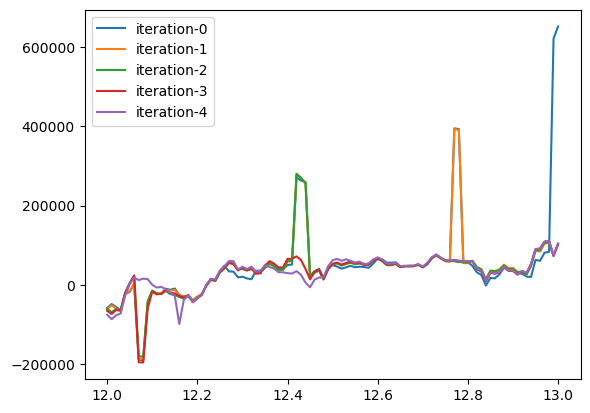

In [19]:
#plot results from different iterations
for i in range(5):
    a = np.loadtxt(f"Fe-ahc_iter-{i:04d}.dat")
    plt.plot(a[:,0],a[:,3],label = f"iteration-{i}")
#plt.ylim(-1000,1000)
plt.legend()
plt.show()

In [20]:
result_run = wberri.run(system,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=10,
            fout_name='Fe',
            restart=True,
            file_Klist="Klist_ahc.pickle"  # needed to restart a calculation
            )

Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
Finished reading Klist from file Klist_ahc.pickle
52 K-points were read from Klist_ahc.pickle
8 K-points were read from Klist_ahc.changed_factors.txt
searching for start_iter
start_iter = 5
iteration 5 - 0 points. New points are:
symgroup : <wannierberri.symmetry.Group object at 0x7f4bd7171280>
nothing to process now
time1 =  0.0032553672790527344
time2 =  0.0018982887268066406
exclude dbg 1 6 [0.35 0.15 0.25] [0.45 0.25 0.15] 8 8
checking for equivalent points in all points (of new  7 points)
 excluded 0 points
sum of weights now :1.0000000000000002
Writing file_Klist_factor_changed to Klist_ahc.changed_factors.txt
iteration 6 - 7 points. New points are:
 K-point 52 : coord in rec.lattice = [   0.350000  ,   0.150000 ,    0.150000 ], refinement level:1, factor = 0.008dK=[0.1 0.1 0.1]  
 K-point 53 : coord in rec.lattice = [   0.350000  ,   0.150000 ,    0.250000 ], refinement level:1, f

time for processing     18 K-points on   2 processes:     0.8501 ; per K-point          0.0472 ; proc-sec per K-point          0.0945
time1 =  0.0007834434509277344
time2 =  0.0028030872344970703
exclude dbg 4 6 [ 0.85  0.35 -0.05] [ 0.85  0.45 -0.05] 8 8
exclude dbg 1 3 [0.75 0.35 0.05] [0.75 0.45 0.05] 8 8
exclude dbg 1 4 [-0.05  0.15  0.05] [ 0.05  0.15 -0.05] 8 8
exclude dbg 0 7 [-0.05  0.15 -0.05] [0.05 0.25 0.05] 8 8
exclude dbg 3 6 [-0.05  0.25  0.05] [ 0.05  0.25 -0.05] 8 8
checking for equivalent points in all points (of new  11 points)
exclude dbg 48 113 [ 0.15  0.05 -0.05] [0.05 0.15 0.05] 114 11
exclude dbg 89 111 [0.05 0.35 0.05] [-0.05  0.25 -0.05] 114 11
exclude dbg 79 105 [ 0.75  0.25 -0.05] [ 0.75  0.45 -0.05] 114 11
 excluded 3 points
sum of weights now :1.0000000000000007
Writing file_Klist_factor_changed to Klist_ahc.changed_factors.txt
iteration 10 - 8 points. New points are:
 K-point 103 : coord in rec.lattice = [   0.750000  ,   0.350000 ,   -0.050000 ], refineme

time for processing      9 K-points on   2 processes:     0.4402 ; per K-point          0.0489 ; proc-sec per K-point          0.0978
time1 =  0.0004677772521972656
time2 =  0.002529621124267578
exclude dbg 1 3 [-0.05 -0.05  0.05] [-0.05  0.05  0.05] 8 8
exclude dbg 1 4 [-0.05 -0.05  0.05] [ 0.05 -0.05 -0.05] 8 8
exclude dbg 1 6 [-0.05 -0.05  0.05] [ 0.05  0.05 -0.05] 8 8
exclude dbg 0 7 [-0.05 -0.05 -0.05] [0.05 0.05 0.05] 8 8
exclude dbg 2 5 [-0.05  0.05 -0.05] [ 0.05 -0.05  0.05] 8 8
exclude dbg 0 7 [0.75 0.35 0.15] [0.85 0.45 0.25] 8 8
exclude dbg 1 3 [0.325 0.325 0.375] [0.325 0.375 0.375] 8 8
exclude dbg 1 4 [0.325 0.325 0.375] [0.375 0.325 0.325] 8 8
exclude dbg 1 6 [0.325 0.325 0.375] [0.375 0.375 0.325] 8 8
checking for equivalent points in all points (of new  15 points)
exclude dbg 48 143 [ 0.15  0.05 -0.05] [-0.05  0.05 -0.05] 156 15
exclude dbg 101 149 [0.65 0.15 0.25] [0.85 0.35 0.25] 156 15
 excluded 2 points
sum of weights now :1.0000000000000007
Writing file_Klist_facto

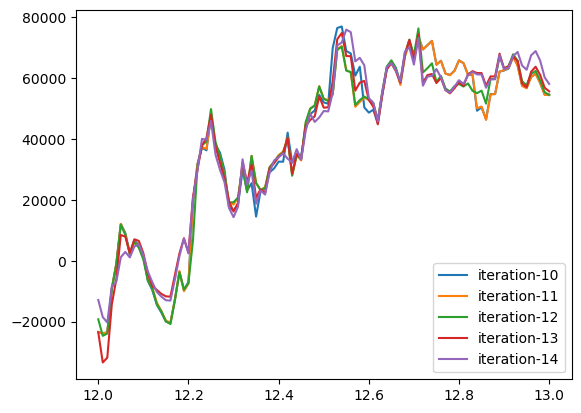

In [21]:
#plot results from different iterations
for i in range(10,15):
    a = np.loadtxt(f"Fe-ahc_iter-{i:04d}.dat")
    ef = a[:,0] 
    ahc_xy = a[:,3]
    # alternatively:
    #res = np.load(f"Fe-ahc_iter-{i:04d}.npz")
    #print (list(res.keys()))
    #ef = res["Energies_0"]
    #ahc_xy = res["data"][:,2]
    plt.plot(ef,ahc_xy,label = f"iteration-{i}")
#plt.ylim(-1000,1000)
plt.legend()
plt.show()

### Problem 3 : 
start from a denser grid (length=100 or 200) and do the integration again with 20 iterations. Plot the results

In [ ]:
# insert the needed code below




## Tetrahedron method

determining grids from NK=None (<class 'NoneType'>), NKdiv=None (<class 'NoneType'>), NKFFT=None (<class 'NoneType'>)
length=50 was converted into NK=[25 25 25]
Minimal symmetric FFT grid :  [4 4 4]
The grids were set to NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
Density of states

Density of states

Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
generating K_list
Done in 0.0009453296661376953 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.008036375045776367 s 
Done in 0.008059263229370117 s 
K_list contains 18 Irreducible points(14.4%) out of initial 5x5x5=125 grid
Done, sum of weights:1.0000000000000004
symgroup : <wannierberri.symmetry.Group object at 0x7f4bd7171280>
processing 18 K points : using  2 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing     18 K-points on   2 processes:     4.1802 ; per K-point          0.2322 ; proc-sec per K-point          0.4645
t

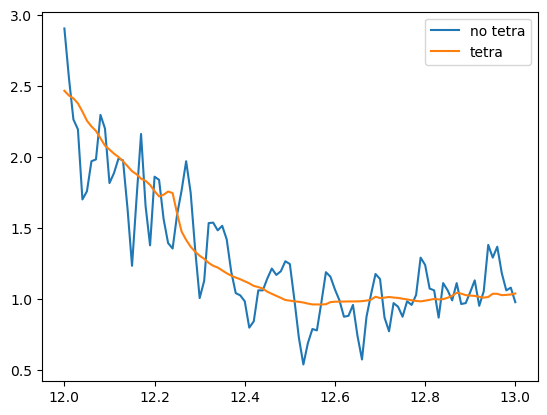

In [22]:
calculators = {}
Efermi = np.linspace(12,13,101)
omega = np.linspace(0,1.,101)
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk

calculators ["dos_notetra"] = wberri.calculators.static.DOS(Efermi=Efermi,tetra=False)
calculators ["dos_tetra"] = wberri.calculators.static.DOS(Efermi=Efermi,tetra=True)

result_run = wberri.run(system,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=0,
            fout_name='Fe',
            suffix = "run2",
            restart=False,
            print_Kpoints=False
            )

a = np.loadtxt(f"Fe-dos_notetra-run2_iter-0000.dat")
plt.plot(a[:,0],a[:,1],label = f"no tetra")
a = np.loadtxt(f"Fe-dos_tetra-run2_iter-0000.dat")
plt.plot(a[:,0],a[:,1],label = f"tetra")
plt.legend()

In [23]:
!ls


bands		      Fe-ahc_iter-0008.dat  Fe_bands+QE.pdf
Fe-ahc_iter-0000.dat  Fe-ahc_iter-0008.npz  Fe_bands+w90.pdf
Fe-ahc_iter-0000.npz  Fe-ahc_iter-0009.dat  Fe-dos_notetra-run2_iter-0000.dat
Fe-ahc_iter-0001.dat  Fe-ahc_iter-0009.npz  Fe-dos_notetra-run2_iter-0000.npz
Fe-ahc_iter-0001.npz  Fe-ahc_iter-0010.dat  Fe-dos_tetra-run2_iter-0000.dat
Fe-ahc_iter-0002.dat  Fe-ahc_iter-0010.npz  Fe-dos_tetra-run2_iter-0000.npz
Fe-ahc_iter-0002.npz  Fe-ahc_iter-0011.dat  input
Fe-ahc_iter-0003.dat  Fe-ahc_iter-0011.npz  Klist_ahc.changed_factors.txt
Fe-ahc_iter-0003.npz  Fe-ahc_iter-0012.dat  Klist_ahc.pickle
Fe-ahc_iter-0004.dat  Fe-ahc_iter-0012.npz  result-tabulate_berry-x.frmsf
Fe-ahc_iter-0004.npz  Fe-ahc_iter-0013.dat  result-tabulate_berry-y.frmsf
Fe-ahc_iter-0005.dat  Fe-ahc_iter-0013.npz  result-tabulate_berry-z.frmsf
Fe-ahc_iter-0005.npz  Fe-ahc_iter-0014.dat  result-tabulate_E.frmsf
Fe-ahc_iter-0006.dat  Fe-ahc_iter-0014.npz  result-tabulate_Energy-.frmsf
Fe-ahc_iter-0006.npz  Fe-ahc_it

## Optical conductivity

In [24]:
calculators = {}
Efermi = np.linspace(12,13,101)
omega = np.linspace(0,1.,101)
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk

calculators["opt_conductivity"] = wberri.calculators.dynamic.OpticalConductivity(
                            Efermi=Efermi,omega=omega)


result_run_opt = wberri.run(system,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=0,
            fout_name='Fe',
            suffix = "run3",
            restart=False,
            )

determining grids from NK=None (<class 'NoneType'>), NKdiv=None (<class 'NoneType'>), NKFFT=None (<class 'NoneType'>)
length=50 was converted into NK=[25 25 25]
Minimal symmetric FFT grid :  [4 4 4]
The grids were set to NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
calculator not described

Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
generating K_list
Done in 0.0014033317565917969 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.007991552352905273 s 
Done in 0.008011102676391602 s 
K_list contains 18 Irreducible points(14.4%) out of initial 5x5x5=125 grid
Done, sum of weights:1.0000000000000004
iteration 0 - 18 points. New points are:
 K-point 0 : coord in rec.lattice = [   0.000000  ,   0.000000 ,    0.000000 ], refinement level:0, factor = 0.008dK=[0.2 0.2 0.2]  
 K-point 1 : coord in rec.lattice = [   0.000000  ,   0.200000 ,    0.000000 ], refinement level:0, factor = 0.032dK=[0.2 0.2 0.2]  
 K-point 2 :

In [25]:
#plot results from new iterations
res = result_run_opt.results["opt_conductivity"]
print (res.data.shape)
print (res.Energies[0]) # Efermi
print (res.Energies[1]) # omega

# plot at fixed omega
iw = 10
plt.plot(res.Energies[0],data[:,iw,2,2].imag)
plt.show()

# plot at fixed Efermi
ief = 20
plt.plot(res.Energies[1],data[ief,:,2,2].imag)
plt.show()


(101, 101, 3, 3)
[12.   12.01 12.02 12.03 12.04 12.05 12.06 12.07 12.08 12.09 12.1  12.11
 12.12 12.13 12.14 12.15 12.16 12.17 12.18 12.19 12.2  12.21 12.22 12.23
 12.24 12.25 12.26 12.27 12.28 12.29 12.3  12.31 12.32 12.33 12.34 12.35
 12.36 12.37 12.38 12.39 12.4  12.41 12.42 12.43 12.44 12.45 12.46 12.47
 12.48 12.49 12.5  12.51 12.52 12.53 12.54 12.55 12.56 12.57 12.58 12.59
 12.6  12.61 12.62 12.63 12.64 12.65 12.66 12.67 12.68 12.69 12.7  12.71
 12.72 12.73 12.74 12.75 12.76 12.77 12.78 12.79 12.8  12.81 12.82 12.83
 12.84 12.85 12.86 12.87 12.88 12.89 12.9  12.91 12.92 12.93 12.94 12.95
 12.96 12.97 12.98 12.99 13.  ]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0

NameError: name 'data' is not defined

In [26]:
!ls

bands		      Fe-ahc_iter-0012.npz
Fe-ahc_iter-0000.dat  Fe-ahc_iter-0013.dat
Fe-ahc_iter-0000.npz  Fe-ahc_iter-0013.npz
Fe-ahc_iter-0001.dat  Fe-ahc_iter-0014.dat
Fe-ahc_iter-0001.npz  Fe-ahc_iter-0014.npz
Fe-ahc_iter-0002.dat  Fe-ahc_iter-0015.dat
Fe-ahc_iter-0002.npz  Fe-ahc_iter-0015.npz
Fe-ahc_iter-0003.dat  Fe_bands+berry.pdf
Fe-ahc_iter-0003.npz  Fe_bands+QE.pdf
Fe-ahc_iter-0004.dat  Fe_bands+w90.pdf
Fe-ahc_iter-0004.npz  Fe-dos_notetra-run2_iter-0000.dat
Fe-ahc_iter-0005.dat  Fe-dos_notetra-run2_iter-0000.npz
Fe-ahc_iter-0005.npz  Fe-dos_tetra-run2_iter-0000.dat
Fe-ahc_iter-0006.dat  Fe-dos_tetra-run2_iter-0000.npz
Fe-ahc_iter-0006.npz  Fe-opt_conductivity-run3_iter-0000.dat
Fe-ahc_iter-0007.dat  Fe-opt_conductivity-run3_iter-0000.npz
Fe-ahc_iter-0007.npz  input
Fe-ahc_iter-0008.dat  Klist_ahc.changed_factors.txt
Fe-ahc_iter-0008.npz  Klist_ahc.pickle
Fe-ahc_iter-0009.dat  result-tabulate_berry-x.frmsf
Fe-ahc_iter-0009.npz  result-tabulate_berry-y.frmsf
Fe-ahc_iter-0010.dat  res

## All in one

In [ ]:
calculators = {}
Efermi = np.linspace(12,13,101)
omega = np.linspace(0,1.,101)
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk

calculators ["ahc_notetra"] = wberri.calculators.static.AHC(Efermi=Efermi,tetra=False)
calculators ["ahc_tetra"] = wberri.calculators.static.AHC(Efermi=Efermi,tetra=True)
calculators ["tabulate"] = wberri.calculators.TabulatorAll({
                            "Energy":wberri.calculators.tabulate.Energy(),
                            "berry":wberri.calculators.tabulate.BerryCurvature(),
                                  },   
                            ibands = np.arange(4,10))
calculators["opt_conductivity"] = wberri.calculators.dynamic.OpticalConductivity(
                            Efermi=Efermi,omega=omega)


result_run = wberri.run(system,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=0,
            fout_name='Fe',
            suffix = "run",
            restart=False,
            )